<a id='intro'></a>
*To [Table of Contents](#toc)*
# Image Super Resolution
## Applied Machine Learning Systems 2
### University College London
#### Department of Electronic and Electrical Engineering
**Student Number:** $20167036$

<img src="./imgs/squirrels.png" alt="Drawing" style="height: 400px;"/>

This project focuses on generating *Super Resolution* (SR) images from *Low Resolution* (LR) ones using deep learning techniques. <br>
More specifically, the project aims at developing and evaluating deep learning models of various architectures for solving the [NTIRE2017 challenge](https://data.vision.ee.ethz.ch/cvl/ntire17/#challenge).

The datasets used for training and evaluating the models may be accessed from the [DIV2K Dataset Website](https://data.vision.ee.ethz.ch/cvl/DIV2K/) 

<a id='toc'></a>
## Table of Contents:
0. [Introduction](#intro)
1. [Loading Data](#load) 
2. [Construct Models](#construct) 
3. [Model Training](#training)
4. [Performance Evaluation](#evaluate)
5. [Credits](#credits)



<a id='load'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/load.png" alt="Drawing" style="height: 80px;"/>
# 1. Loading Data

Set directory (Notebooks are not hosted in base directory)

In [1]:
import os

os.chdir('..')

Instantiate datahandler

In [2]:
from ISR.utils import datahandler as ISR_dh

# Define parameters for the training task, let's use 48x48 patches for the x2 downscaled images
lr_patch_size = 48
scale         = 2
batch_size    = 4

# We now create a datahandler for the training, and point it to the location of the LR and HR images
datahandler = ISR_dh.DataHandler(lr_dir = './Datasets/DIV2K_train_LR_bicubic/X2/',
                                 hr_dir = './Datasets/DIV2K_train_HR/',
                                 patch_size = lr_patch_size, 
                                 scale = scale,
                                 n_validation_samples = 40)

# Generate a validation set
validation_set = datahandler.get_validation_set(batch_size = batch_size)

<a id='construct'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/construction.png" alt="Drawing" style="height: 75px;"/>
# 2. Construct Models

I'll now define a couple of different model architectures, with varying:
- Numbers of convolutional and deconvolutional layers
- Filter layer depths
- Kernel sizes
- Stride 

In [3]:
params_1 = {'conv_layers'         : 4, 
            'conv_filters'        : [32, 64, 64, 32],
            'conv_kernel_sizes'   : [(3,3),(3,3),(3,3),(3,3),(3,3)],
            'conv_strides'        : [(1,1),(1,1),(1,1),(1,1),(1,1)],
            'deconv_layers'       : 1, 
            'deconv_filters'      : [3],
            'deconv_kernel_sizes' : [(2,2)],
            'deconv_strides'      : [(2,2)]}

params_2 = {'conv_layers'         : 5, 
            'conv_filters'        : [32, 64, 64, 64, 32],
            'conv_kernel_sizes'   : [(3,3),(3,3),(3,3),(3,3),(3,3)],
            'conv_strides'        : [(1,1),(1,1),(1,1),(1,1),(1,1)],
            'deconv_layers'       : 1, 
            'deconv_filters'      : [3],
            'deconv_kernel_sizes' : [(2,2)],
            'deconv_strides'      : [(2,2)]}

params_3 = {'conv_layers'         : 5, 
            'conv_filters'        : [32, 64, 64, 64, 32],
            'conv_kernel_sizes'   : [(9,9),(6,6),(3,3),(3,3),(3,3)],
            'conv_strides'        : [(1,1),(1,1),(1,1),(1,1),(1,1)],
            'deconv_layers'       : 1, 
            'deconv_filters'      : [3],
            'deconv_kernel_sizes' : [(2,2)],
            'deconv_strides'      : [(2,2)]}

parameters_list = [params_1, params_2, params_3]

Now, I'll populate a list of models with the parameters from above

In [4]:
from Modules import model as m

models = []

for parameters in parameters_list:
    models.append(m.SRCNN(**parameters))

<a id='training'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/training.png" alt="Drawing" style="height: 90px;"/>
# 3. Model Training

Load models

In [5]:
from Modules import user_interface as ui

In [6]:
if ui.yes_no_menu('Load stored model weights (y/n) ? '):
    for model in models:
        model.loadWeights()

Load stored model weights (y/n) ? no


In [7]:
if ui.yes_no_menu('Train model (y/n) ? '):
    
    epochs = int(input('Number of epochs to run: '))
    
    for model in models:
        print('Training: \n{}'.format(model.model.name))
        model.train(total_epochs   = epochs,
                    batch_size     = 4,
                    datahandler    = datahandler,
                    validation_set = validation_set)

Train model (y/n) ? yes
Number of epochs to run: 15
Training: 
Conv-4_Flt-32-64-64-32_Krnl-33-33-33-33-33_Strd-11-11-11-11-11-Deconv-1_Flt-3_Krnl-22_Strd-22
------------------------------------------------------------
            ... Initiating Training Session ...             
------------------------------------------------------------
------------------------------------------------------------
                    E P O C H   1/15                    
------------------------------------------------------------
 Runtime                   ==> 127.15857696533203s
 train_loss                ==> 0.009033456444740295
 train_psnr                ==> 20.559646606445312
 train_ssim                ==> 0.8376437425613403
 val_loss                  ==> 0.015884657891001554
 val_psnr                  ==> 19.210886001586914
 val_ssim                  ==> 0.7863794565200806
Model weights saved to: ./Models/SRCNN/Conv-4_Flt-32-64-64-32_Krnl-33-33-33-33-33_Strd-11-11-11-11-11-Deconv-1_Flt-3_Krnl-22_S

------------------------------------------------------------
                    E P O C H   10/15                    
------------------------------------------------------------
 Runtime                   ==> 123.9724509716034s
 train_loss                ==> 0.0014934277860447764
 train_psnr                ==> 29.22679901123047
 train_ssim                ==> 0.9802518486976624
 val_loss                  ==> 0.0017224045906914399
 val_psnr                  ==> 30.77255630493164
 val_ssim                  ==> 0.9795118570327759
------------------------------------------------------------
                    E P O C H   11/15                    
------------------------------------------------------------
 Runtime                   ==> 120.50774502754211s
 train_loss                ==> 0.0006069467635825276
 train_psnr                ==> 32.53966522216797
 train_ssim                ==> 0.9858115911483765
 val_loss                  ==> 0.0016117829116410575
 val_psnr                  ==>

------------------------------------------------------------
                    E P O C H   5/15                    
------------------------------------------------------------
 Runtime                   ==> 136.68184685707092s
 train_loss                ==> 0.00337525294162333
 train_psnr                ==> 24.778900146484375
 train_ssim                ==> 0.9531999826431274
 val_loss                  ==> 0.002461625412252033
 val_psnr                  ==> 28.88397789001465
 val_ssim                  ==> 0.9616091847419739
Model weights saved to: ./Models/SRCNN/Conv-5_Flt-32-64-64-64-32_Krnl-33-33-33-33-33_Strd-11-11-11-11-11-Deconv-1_Flt-3_Krnl-22_Strd-22/
************************************************************
Best model weights w/ val loss 0.002462 saved to ./Models/SRCNN/Conv-5_Flt-32-64-64-64-32_Krnl-33-33-33-33-33_Strd-11-11-11-11-11-Deconv-1_Flt-3_Krnl-22_Strd-22/
************************************************************
-----------------------------------------------

------------------------------------------------------------
                    E P O C H   15/15                    
------------------------------------------------------------
 Runtime                   ==> 127.78169107437134s
 train_loss                ==> 0.0008316009771078825
 train_psnr                ==> 31.18768882751465
 train_ssim                ==> 0.9872986674308777
 val_loss                  ==> 0.0016800571662315632
 val_psnr                  ==> 30.560583114624023
 val_ssim                  ==> 0.9824897050857544
Training: 
Conv-5_Flt-32-64-64-64-32_Krnl-99-66-33-33-33_Strd-11-11-11-11-11-Deconv-1_Flt-3_Krnl-22_Strd-22
------------------------------------------------------------
            ... Initiating Training Session ...             
------------------------------------------------------------
------------------------------------------------------------
                    E P O C H   1/15                    
-------------------------------------------------------

------------------------------------------------------------
                    E P O C H   9/15                    
------------------------------------------------------------
 Runtime                   ==> 135.77826595306396s
 train_loss                ==> 0.004610558971762657
 train_psnr                ==> 24.618017196655273
 train_ssim                ==> 0.9504929780960083
 val_loss                  ==> 0.003141183657862712
 val_psnr                  ==> 27.505178451538086
 val_ssim                  ==> 0.9515743255615234
------------------------------------------------------------
                    E P O C H   10/15                    
------------------------------------------------------------
 Runtime                   ==> 137.72031593322754s
 train_loss                ==> 0.006606795825064182
 train_psnr                ==> 22.274715423583984
 train_ssim                ==> 0.953072726726532
 val_loss                  ==> 0.002660618841764517
 val_psnr                  ==> 2

<a id='evaluate'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/evaluate.png" alt="Drawing" style="height: 80px;"/>
# 4. Performance Evaluation

## 4.1 Learning Curves

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

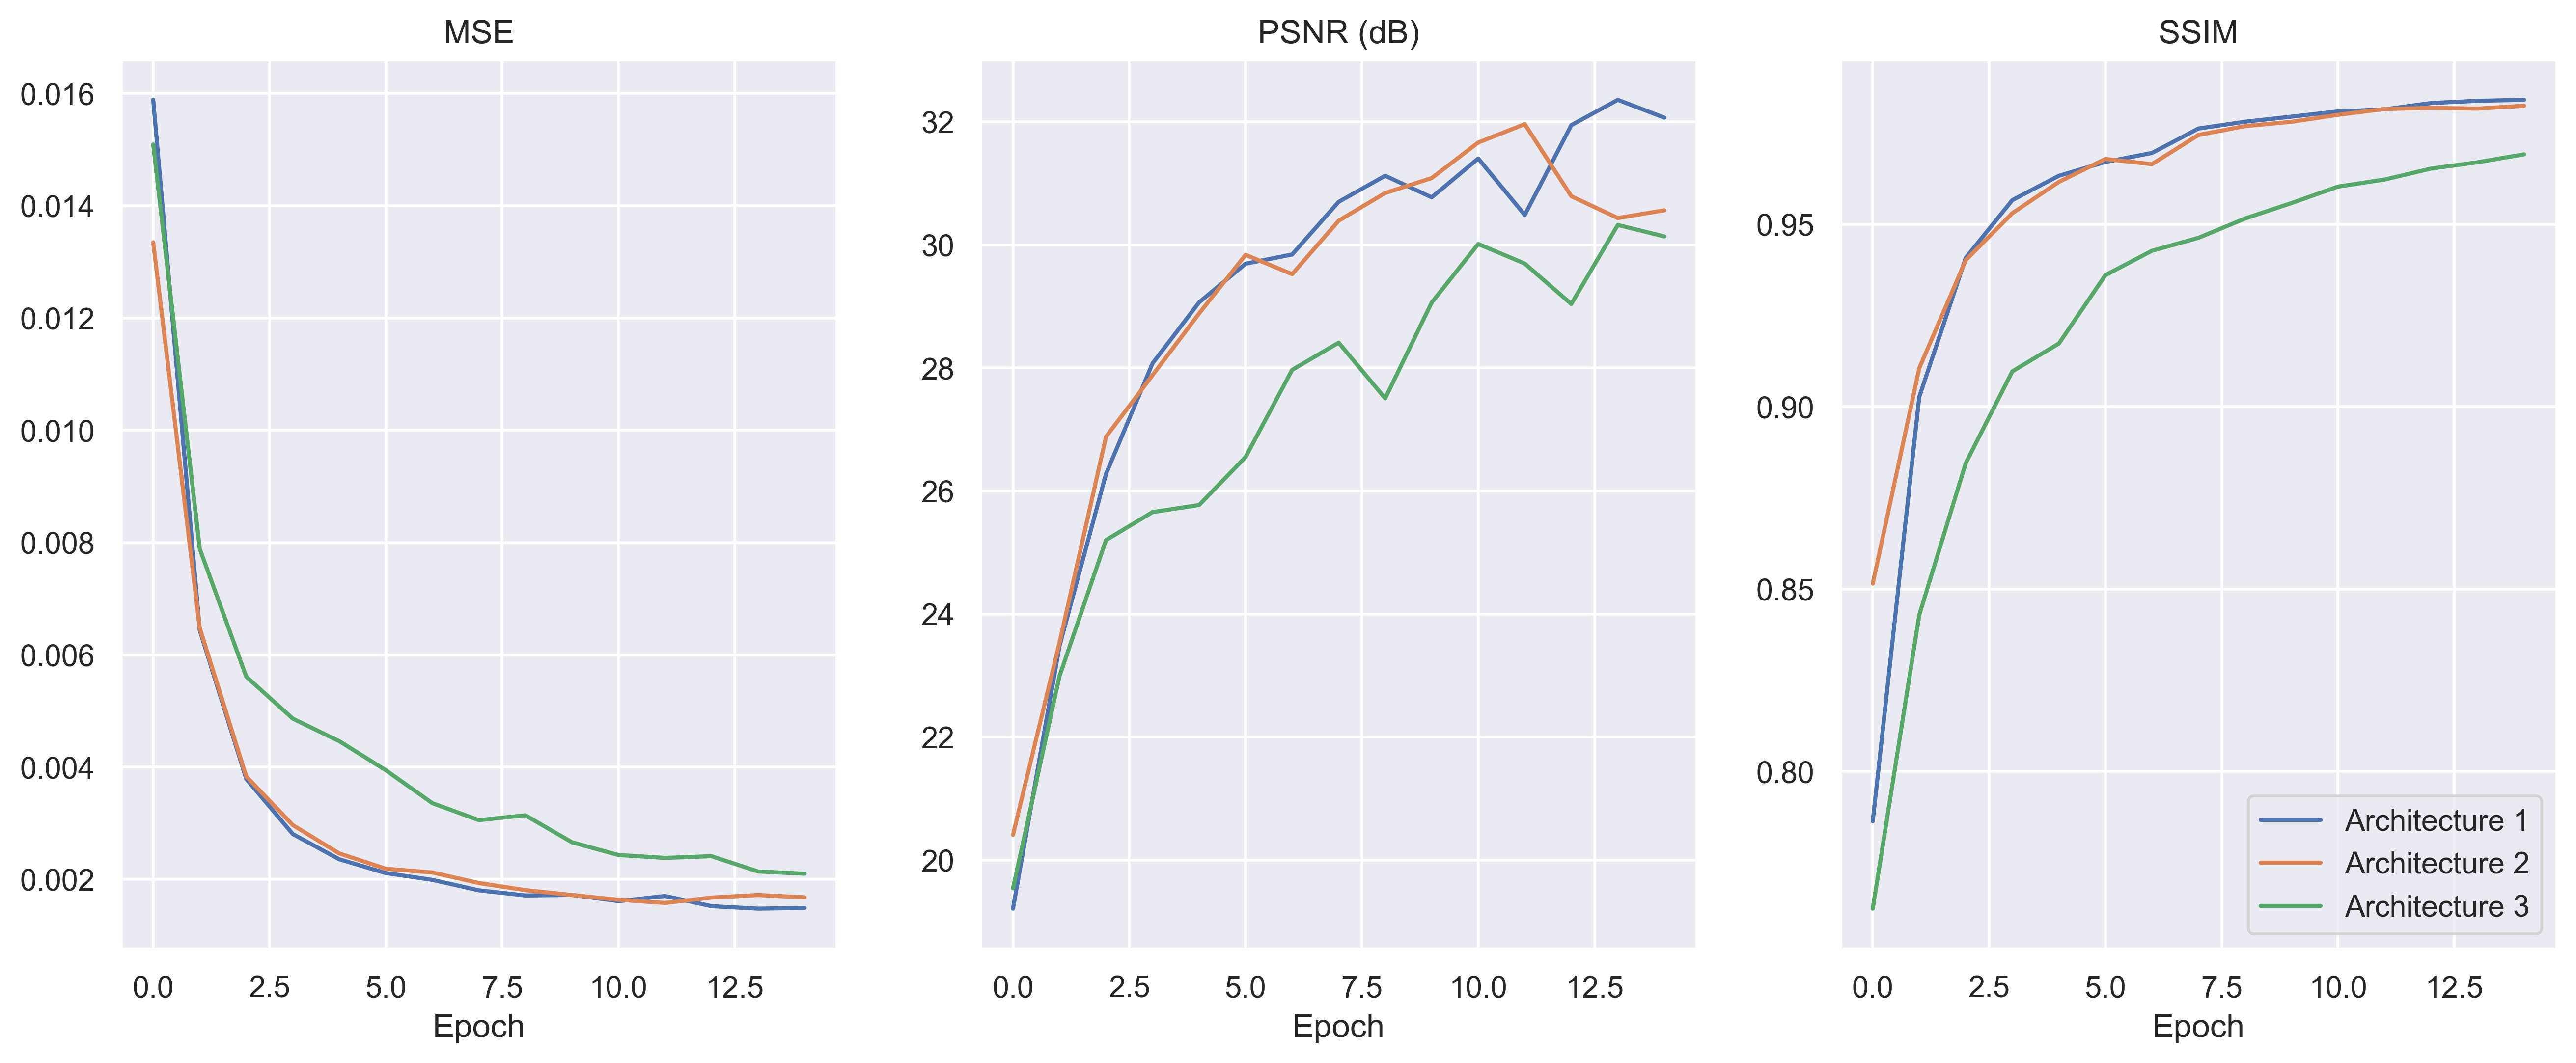

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(16,6),dpi=400)

metrics = ['val_loss','val_psnr','val_ssim']
names   = ['MSE','PSNR (dB)','SSIM']

for plot,metric,name in zip(ax.ravel(),metrics,names):
    plot.plot(models[0].val_history[metric])
    plot.plot(models[1].val_history[metric])
    plot.plot(models[2].val_history[metric])
    plot.set_title(name)
    plot.set_xlabel('Epoch')

plt.legend(['Architecture 1','Architecture 2','Architecture 3'])
plt.show()

In [10]:
models[0].model.name

'Conv-4_Flt-32-64-64-32_Krnl-33-33-33-33-33_Strd-11-11-11-11-11-Deconv-1_Flt-3_Krnl-22_Strd-22'

In [11]:
models[1].model.name

'Conv-5_Flt-32-64-64-64-32_Krnl-33-33-33-33-33_Strd-11-11-11-11-11-Deconv-1_Flt-3_Krnl-22_Strd-22'

In [12]:
models[2].model.name

'Conv-5_Flt-32-64-64-64-32_Krnl-99-66-33-33-33_Strd-11-11-11-11-11-Deconv-1_Flt-3_Krnl-22_Strd-22'

## 4.2 Test Set

In [14]:
from Modules import data_processing as dp
from Modules import metrics

In [15]:
x2_bc_test  = dp.loadImages(directory       = './Datasets/DIV2K_valid_LR_bicubic/X2/',
                            file_extension  = '.png',
                            loading_message = 'Loading [x2] Bi-Cubic Downsampled Testing Images ')
y_test      = dp.loadImages(directory       = './Datasets/DIV2K_valid_HR/',
                            file_extension  = '.png',
                            loading_message = 'Loading High Resolution Testing Images \t\t')

Loading [x2] Bi-Cubic Downsampled Testing Images  |████████████████████| 100.0% 
Loading High Resolution Testing Images 		 |████████████████████| 100.0% 


In [16]:
x2_bc_test = dp.reshapeImgs(x2_bc_test)
y_test     = dp.reshapeImgs(y_test)

In [17]:
mse  = 0
psnr = 0
ssim = 0

for sample,label in zip(x2_bc_test, y_test):
    
    y_pred  = models[0].model.predict(sample)
    y_pred[y_pred > 1] = 1
    results = metrics.evaluate(y_pred[0], label[0])
    
    mse  += results['MSE']
    psnr += results['PSNR']
    ssim += results['SSIM']

n_samples = len(x2_bc_test)

test_scores = {'MSE' : mse  / n_samples,
               'PSNR': psnr / n_samples,
               'SSIM': ssim / n_samples}

/opt/anaconda3/envs/AMLS_II_Final/lib/python3.6/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [18]:
print('Average metric values on test set:')
print(test_scores)

Average metric values on test set:
{'MSE': 0.001227109829646627, 'PSNR': 30.837654099766738, 'SSIM': 0.9382954469388675}


<a id='credits'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/credits.png" alt="Drawing" style="height: 80px;"/>
# 5. Credits


Chapter Title Icons: <a href="www.flaticon.com">Flaticon.com</a>. <br>
This notebook has been designed using resources from <a href="www.flaticon.com">Flaticon.com </a>